# Home Loans Practice 2

Some things to bear in mind from the last time I was working on this.

1. The classes are very uneven where most people don't defualt so when running a classifier the best prediction is that no one defaults at least for a very simple model. I would consider fixing this but the end result for this compition is to provide the probability of the target variable. So I would think I wouldn't need to account for this since accounting for this would hurt my accuracy of predicting the probability of the target. But it is something to think about.

2. I only looked at 2 of the columns from the training file there are many more columns in this file as well as other other files I could be using. Maybe I could set up a SQL server so I can more easily combine these files and get some experience working with SQL.

3. I only used tree models and gradient boosting. I really don't know how to optimize the gradient boosting algorithm so I might look into how that is done. Maybe try other models.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

In [2]:
test = pd.read_csv("C:\\Users\\Andrew\\Documents\\Practice\\Home Loans\\application_test.csv")
train = pd.read_csv("C:\\Users\\Andrew\\Documents\\Practice\\Home Loans\\application_train.csv")
bureau = pd.read_csv("C:\\Users\\Andrew\\Documents\\Practice\\Home Loans\\bureau.csv")
bureau_balance = pd.read_csv("C:\\Users\\Andrew\\Documents\\Practice\\Home Loans\\bureau_balance.csv")
POS_CASH_balance = pd.read_csv("C:\\Users\\Andrew\\Documents\\Practice\\Home Loans\\POS_CASH_balance.csv")
credit_card_balance = pd.read_csv("C:\\Users\\Andrew\\Documents\\Practice\\Home Loans\\credit_card_balance.csv")
previous_application = pd.read_csv("C:\\Users\\Andrew\\Documents\\Practice\\Home Loans\\previous_application.csv")
installments_payments = pd.read_csv("C:\\Users\\Andrew\\Documents\\Practice\\Home Loans\\installments_payments.csv")

In [3]:
def hot_fix(column):
        names = list(column[1])
        column = column[0]
        u = np.unique(column)
        if -1 in u:
            names = ["nan"] + names
        res = np.zeros((column.shape[0],u.shape[0]))
        for i in range(u.shape[0]):
            res[0:,i] = column == u[i]
        res = pd.DataFrame(res)
        res.columns = names
        return res

First I want to try selecting the best parameters for my simple tree model in the first part.
To do this I will use cross validation and the area under the ROC curve. I think I will make my own cross validation model just because I want to make sure I know what is going on.

In [4]:
def find_index(current_cross,size,crosses):
    # Function that divides a range of numbers into sections
    train = np.arange(size)
    start = current_cross*int(round(size/crosses,0))
    end = start + int(round(size/crosses,0))
    # I feel like this should be size -1 but I haven't run into any problems
    if end > size:
        end = size
    test = train[start:end]
    # Making this a set finding the difference and making it a list in probably dumb
    train = train[list(set(train).difference(set(test)))]
    return train,test

def cross_validation(train,factors,model,crosses=6):
    mask = np.random.permutation(train.shape[0])
    res = 0 
    for i in range(crosses):   
        train_index,test_index = find_index(i,train.shape[0],crosses)
        # I'm not sure I really need to copy here
        train1 = train.iloc[mask[train_index]].copy()
        test1 = train.iloc[mask[test_index]].copy()
        model.fit(train1[factors], train1['TARGET'])
        y_prob = model.predict_proba(test1[factors])
        res = res + sk.metrics.roc_auc_score(test1['TARGET'],y_prob[0:,1])
    return res/crosses

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Split occupation type into indicator variables
oc_type = pd.DataFrame(hot_fix(train['OCCUPATION_TYPE'].factorize()))
train1 = pd.concat([train.reset_index(drop=True),oc_type],axis =1)
factors = ['CNT_CHILDREN'] + list(oc_type.columns)

I made a mistake and left the max depth the same. Thought it was a little interesting so I left it

In [6]:
res = np.zeros(10)
for i in range(10):
    tree_model = DecisionTreeClassifier(max_depth=3)
    res[i] = cross_validation(train1,factors,tree_model)

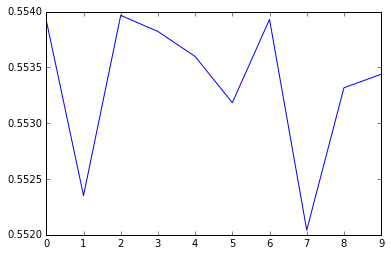

In [7]:
plt.figure()
plt.plot(np.arange(10),res)
plt.show()

In [8]:
res = np.zeros(20)
for i in range(20):
    tree_model = DecisionTreeClassifier(max_depth=i+1)
    res[i] = cross_validation(train1,factors,tree_model)

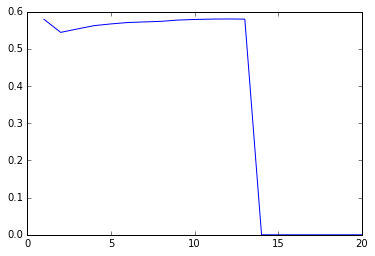

In [13]:
plt.figure()
plt.plot(np.arange(20)+1,res)
plt.show()

As you can see the AUC really levels off with trees at a max depth around 10.

In [10]:
tree_model = DecisionTreeClassifier(max_depth=10,criterion = "entropy")
cross_validation(train1,factors,tree_model)

0.57907290377732934

Well thats about all the options for a tree classifier that I wanted to test. Let's move on to the gradiant boosting algorithm. So there area a lot more parameters to test here but I think the main ones are the learning rate and n_estimators.

In [12]:
i=0
boost_model = GradientBoostingClassifier(learning_rate=(i+1)/20)
res[i] = cross_validation(train1,factors,boost_model)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
res = np.zeros(20)
for i in range(20):
    boost_model = GradientBoostingClassifier(learning_rate=(i+1)/20)
    res[i] = cross_validation(train1,factors,boost_model)

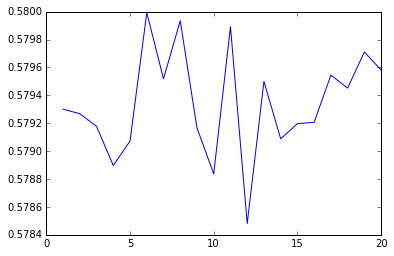

In [15]:
plt.figure()
plt.plot(np.arange(20)+1,res)
plt.show()

The best learning rate seems to be around .35. Though there really isn't that strong of a pattern in this.